In [1]:
# IMPORT BLOCK
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(threshold=np.inf, linewidth=np.inf, precision=8, suppress=True)
from openflash.multi_equations import wavenumber

import sys
from pathlib import Path
HERE = Path.cwd().resolve()
slants_dir = (HERE / "..").resolve()
if str(slants_dir) not in sys.path:
    sys.path.insert(0, str(slants_dir))

condensed_dir = str((HERE / ".." / "..").resolve)
if condensed_dir not in sys.path:
    sys.path.insert(0, condensed_dir)

from capytaine_generator import CapytaineSlantSolver
from modified_meem import SProblem, solve_modified_problem, slant_approx_vars, update_data_file
from multi_condensed import Problem

In [2]:
# Config variables
big_nmk = 300
subdivisions = 30

rho = 1023
g = 9.81
h = 50.00
freq = 1
m0 = wavenumber(freq, h)
d_in = [14.45]
d_out = [1e-4]
a = [4.2]
heaving = [1]
NMK = [big_nmk, big_nmk]

t_densities = [40]
face_units = 100
f_densities = None

plot_res_r, plot_res_z = 150, 150
frame1 = {"r_min" : 0.8, "r_max" :1.16, "z_min" : -12.1, "z_max" : -10.5}
frame2 = {"r_min" : 0.73, "r_max" :1.09, "z_min" : -12.1, "z_max" : -10.5}
frame3 = {"r_min" : 0, "r_max" : 6, "z_min" : -50, "z_max" : 0}

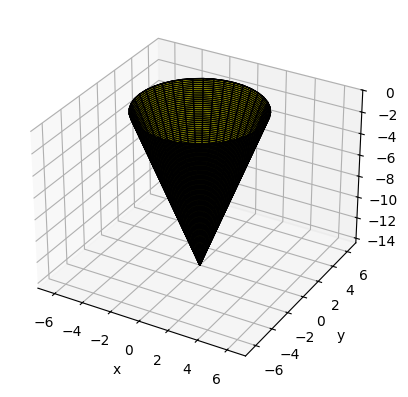

Panel Count:  4000
{'Heave': 56306.531556153604}
{'Heave': 45670.66232355093}
Solve Time (Radiation):  309.7275059139938
Solve Time (Diffraction):  247.37484723201487
Excitation Phase:  -0.16939153040207353


In [3]:
# Get Capytaine rad_result
css = CapytaineSlantSolver(True, True, True, True, True)
respack = css.construct_and_solve(a, d_in, d_out, heaving, t_densities, face_units, h, m0, rho, 1, f_densities)
rad_result = respack[0]

In [88]:
x1, cs1, prob1 = solve_modified_problem(h, a, d_in, d_out, heaving, m0, rho, subdivisions, 1, NMK = NMK)
x2, cs2, prob2 = solve_modified_problem(h, a, d_in, d_out, heaving, m0, rho, subdivisions, 2, NMK = NMK)

In [4]:
# Data for plotting generation
def get_CPT_potentials(css, rad_result, frame, plot_res_r, plot_res_z, freq):
  r_coords = np.linspace(frame["r_min"], frame["r_max"], plot_res_r)
  z_coords = np.linspace(frame["z_min"], frame["z_max"], plot_res_z)
  R, Z = np.meshgrid(r_coords, z_coords)

  is_inside = css.get_body_bounds_from_regions(a, d_in, d_out)
  r_flat, z_flat = R.ravel(), Z.ravel()
  valid_mask = np.array([(not is_inside(r, z)) for r, z in zip(r_flat, z_flat)])
  valid_points = np.column_stack((r_flat[valid_mask],
                                np.full(np.sum(valid_mask), 0),
                                z_flat[valid_mask]))
  valid_results = css.solver.compute_potential(valid_points, rad_result)
  result = np.full(R.size, np.nan + np.nan*1j)
  result[valid_mask] = valid_results
  meem_form = result.reshape(R.shape) * 1j / freq
  return R, Z, np.real(meem_form), np.imag(meem_form)

def get_MEEM_potential_rectangle(prob, cs, region, r_coords, z_coords):
  h, nmk = prob.h, prob.NMK[region]
  r_dim, z_dim = r_coords.size, z_coords.size

  if region == prob.boundary_count:
    c_arrays = []
    for n in range(nmk):
      lambda_vals = np.vectorize(prob.Lambda_k, otypes=[complex])(n, r_coords)
      z_vals = np.vectorize(prob.Z_k_e, otypes=[complex])(n, z_coords)
      c_arrays.append(np.outer(z_vals, lambda_vals))
  else:
    c_arrays = []
    for n in range(nmk):
      r1_vals = np.vectorize(prob.R_1n, otypes=[complex])(n, r_coords, region)
      z_vals = np.vectorize(prob.Z_n_i, otypes=[complex])(n, z_coords, region)
      c_arrays.append(np.outer(z_vals, r1_vals))
    if region != 0:
      for n in range(nmk):
        r2_vals = np.vectorize(prob.R_2n, otypes=[complex])(n, r_coords, region)
        z_vals = np.vectorize(prob.Z_n_i, otypes=[complex])(n, z_coords, region)
        c_arrays.append(np.outer(z_vals, r2_vals))
  c_array = np.stack(c_arrays)
  h_arr = np.tensordot(np.array(cs[region]), c_array, axes=(0, 0))

  if region == prob.boundary_count:
    return h_arr
  elif prob.heaving[region] == True:
    d = prob.d[region]
    prefactor = 1 / (2 * (h-d))
    particular_r = prefactor * (- (r_coords**2) / 2)
    particular_z = prefactor * ((z_coords + h) ** 2)
    particular_r_arr = np.outer(np.full(z_dim, 1), particular_r)
    particular_z_arr = np.outer(particular_z, np.full(r_dim, 1))
    p_arr = particular_r_arr + particular_z_arr
    return p_arr + h_arr
  else:
    return h_arr

def get_MEEM_potentials(prob, cs, frame, plot_res_r, plot_res_z):
  r_coords = np.linspace(frame["r_min"], frame["r_max"], plot_res_r)
  z_coords = np.linspace(frame["z_min"], frame["z_max"], plot_res_z)
  R, Z = np.meshgrid(r_coords, z_coords)
  result = np.full_like(R, np.nan + np.nan*1j, dtype=complex)

  inc_region = prob.det_region(frame["r_min"])
  inc_r_min, inc_r_max = frame["r_min"], frame["r_min"]
  inc_idx_min, inc_idx_max = 0, 0
  for idx in range(len(r_coords)):
    r = r_coords[idx]
    region = prob.det_region(r)
    if region != inc_region or r == frame["r_max"]:
      region_results = get_MEEM_potential_rectangle(prob, cs, inc_region,
                                                    np.linspace(inc_r_min, inc_r_max, inc_idx_max - inc_idx_min),
                                                    z_coords)
      result[:, inc_idx_min:inc_idx_max] = region_results
      inc_region = region
      inc_r_min, inc_idx_min = r, idx
    inc_r_max, inc_idx_max = r, idx + 1
  region_results = get_MEEM_potential_rectangle(prob, cs, inc_region,
                                                np.linspace(inc_r_min, inc_r_max, inc_idx_max - inc_idx_min),
                                                z_coords)
  result[:, inc_idx_min:inc_idx_max] = region_results
  return R, Z, np.real(result), np.imag(result)



In [5]:
R1, Z1, cpt1_real_phi, cpt1_imag_phi = get_CPT_potentials(css, rad_result, frame1, plot_res_r, plot_res_z, freq)
R2, Z2, cpt2_real_phi, cpt2_imag_phi = get_CPT_potentials(css, rad_result, frame2, plot_res_r, plot_res_z, freq)
R3, Z3, cpt3_real_phi, cpt3_imag_phi = get_CPT_potentials(css, rad_result, frame3, plot_res_r, plot_res_z, freq)

In [ ]:
R1, Z1, mod1_real_phi, mod1_imag_phi = get_MEEM_potentials(prob1, cs1, frame1, plot_res_r, plot_res_z)
R2, Z2, mod2_real_phi, mod2_imag_phi = get_MEEM_potentials(prob2, cs2, frame2, plot_res_r, plot_res_z)
R3, Z3, mod13_real_phi, mod13_imag_phi = get_MEEM_potentials(prob1, cs1, frame3, plot_res_r, plot_res_z)
R3, Z3, mod23_real_phi, mod23_imag_phi = get_MEEM_potentials(prob2, cs2, frame3, plot_res_r, plot_res_z)

In [6]:
def apply_slanted_outline(css, R, Z, phi):
  is_inside = np.vectorize(css.get_body_bounds_from_regions(a, d_in, d_out))
  return np.where(is_inside(R, Z), np.nan, phi)

def plot_meem_outline(prob, ax, frame):
  min_region = prob.det_region(frame["r_min"])
  max_region = prob.det_region(frame["r_max"])
  region_list = list(range(min_region, max_region))
  xs = [frame["r_min"]] + [prob.a[region] for region in region_list for i in range(2)] + [frame["r_max"]]
  ys = [-prob.d[region] for region in region_list for i in range(2)] + [(-prob.d[max_region] if max_region != prob.boundary_count else 0) for i in range(2)]
  ax.plot(xs, ys, color = "black", zorder = 2)
  
def comparison(css, prob, frame, R, Z, cpt_phi, mod_phi, title):
  mod_phi = apply_slanted_outline(css, R, Z, mod_phi)
  abs_diff = mod_phi - cpt_phi
  frac_diff = abs_diff / cpt_phi
  fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex='all', sharey='all', constrained_layout=True)
  vmin, vmax = min(np.nanmin(cpt_phi), np.nanmin(mod_phi)), max(np.nanmax(cpt_phi), np.nanmax(mod_phi))
  levels = np.linspace(vmin, vmax, 50)
  axs[0,0].contourf(R, Z, cpt_phi, levels=levels, cmap='viridis')
  ctf1 = axs[0,1].contourf(R, Z, mod_phi, levels=levels, cmap='viridis')
  for ax in [axs[0,1], axs[1,0], axs[1,1]]:
    plot_meem_outline(prob, ax, frame)
  ctf2 = axs[1,0].contourf(R, Z, abs_diff, levels=50, cmap='hot')
  ctf3 = axs[1,1].contourf(R, Z, frac_diff, levels=50, cmap='hot')
  fig.colorbar(ctf1, ax=axs[0, :], shrink=0.6, location='right')
  fig.colorbar(ctf2, ax=axs[1, 0], shrink=0.6)
  fig.colorbar(ctf3, ax=axs[1, 1], shrink=0.6)
  axs[0,0].set_ylabel("Vertical Distance (r)")
  axs[1,0].set_ylabel("Vertical Distance (r)")
  axs[1,0].set_xlabel("Radial Distance (r)")
  axs[1,1].set_xlabel("Radial Distance (r)")
  axs[0,0].set_title("Capytaine")
  axs[0,1].set_title("Modified MEEM")
  axs[1,0].set_title("Absolute Difference")
  axs[1,1].set_title("Relative Difference")
  fig.suptitle(title, fontsize=16)
  plt.show()

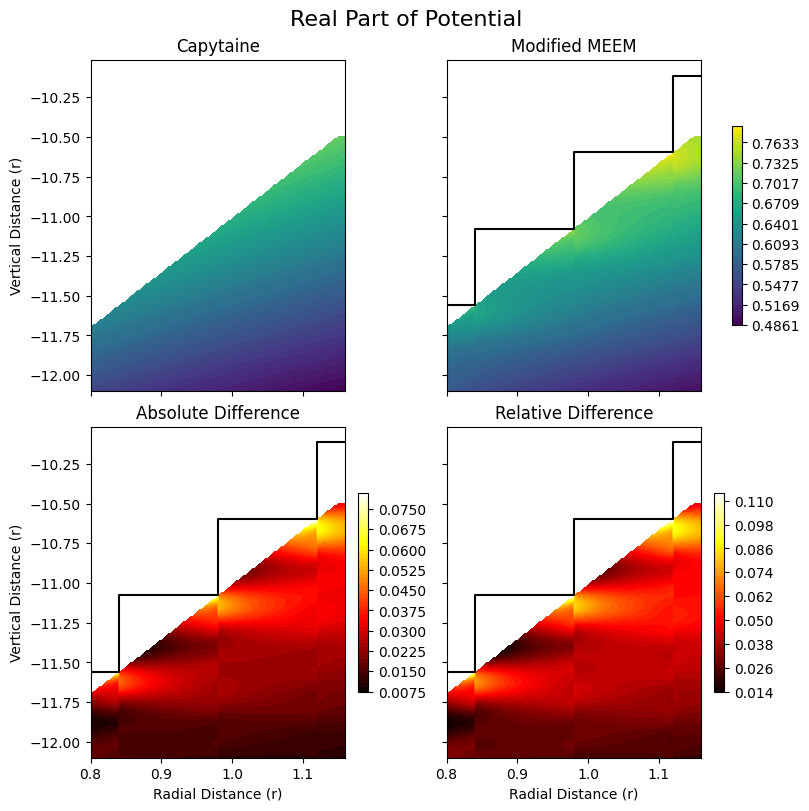

In [152]:
comparison(css, prob1, frame1, R1, Z1, cpt1_real_phi, mod1_real_phi, "Real Part of Potential")

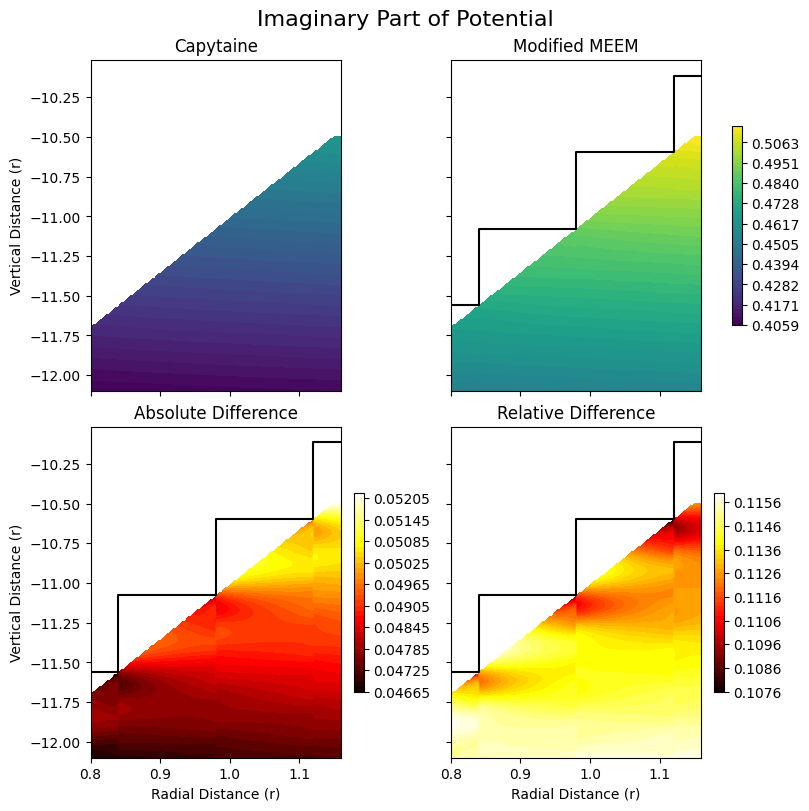

In [153]:
comparison(css, prob1, frame1, R1, Z1, cpt1_imag_phi, mod1_imag_phi, "Imaginary Part of Potential")

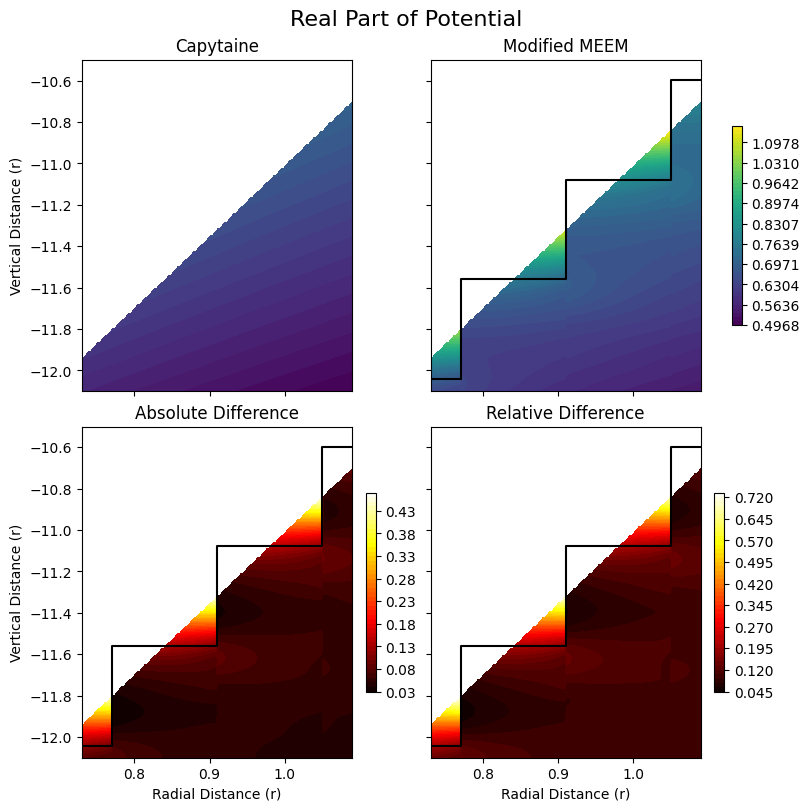

In [154]:
comparison(css, prob2, frame2, R2, Z2, cpt2_real_phi, mod2_real_phi, "Real Part of Potential")

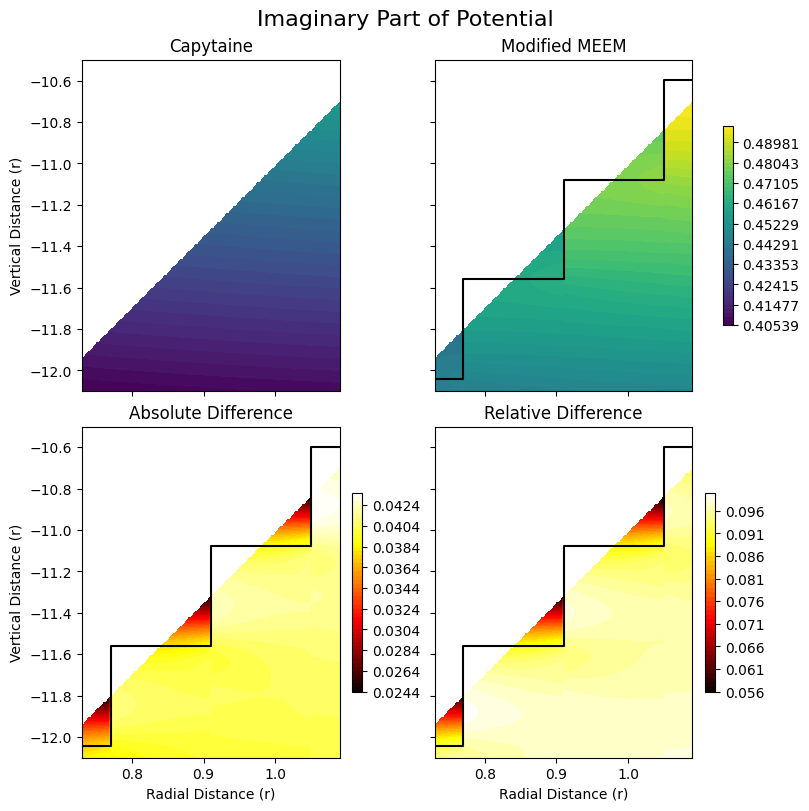

In [155]:
comparison(css, prob2, frame2, R2, Z2, cpt2_imag_phi, mod2_imag_phi, "Imaginary Part of Potential")

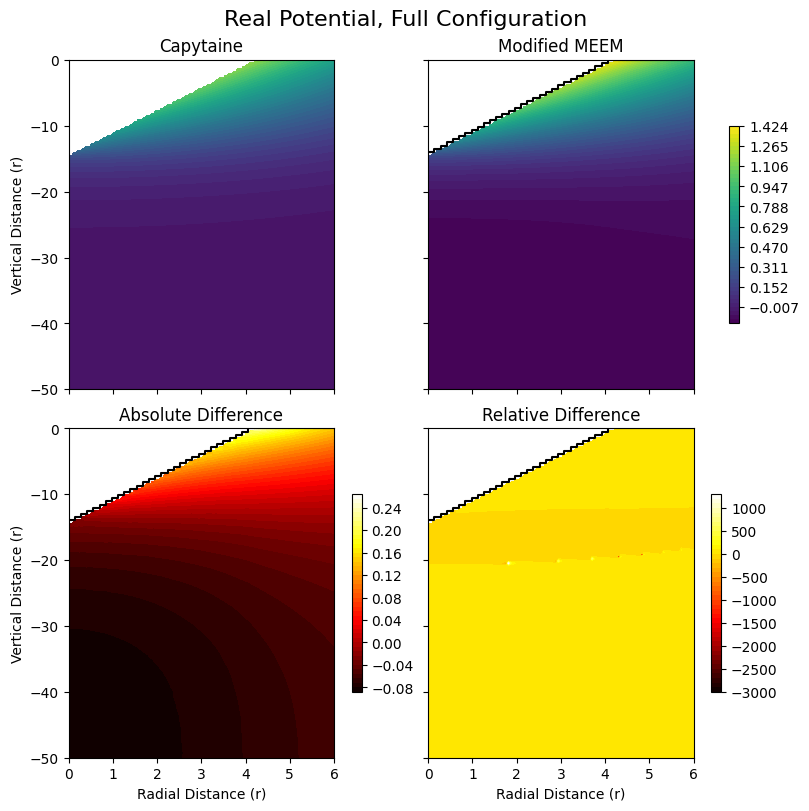

In [156]:
comparison(css, prob1, frame3, R3, Z3, cpt3_real_phi, mod13_real_phi, "Real Potential, Full Configuration")

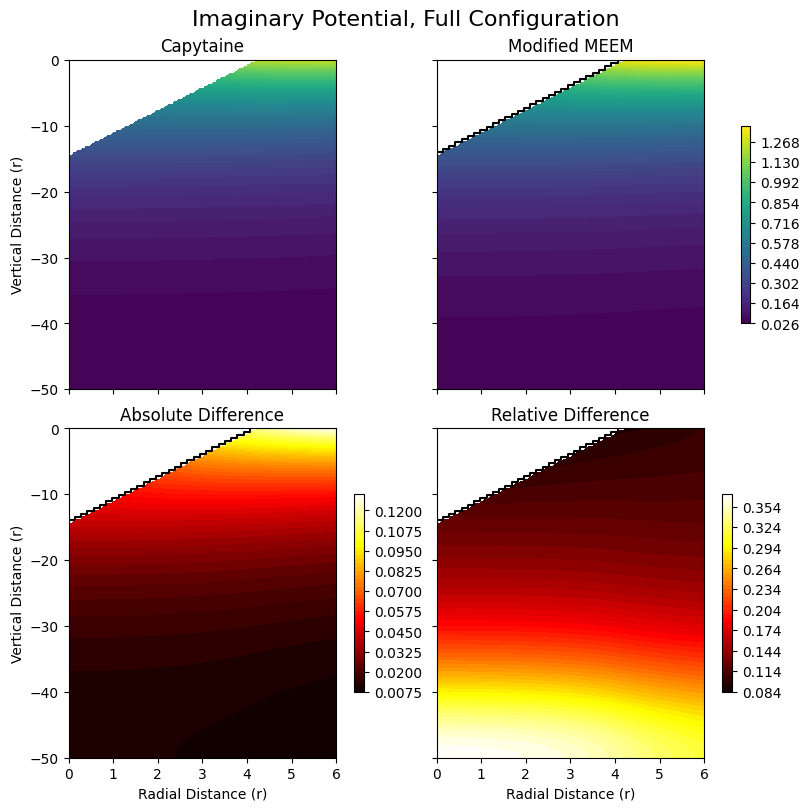

In [157]:
comparison(css, prob1, frame3, R3, Z3, cpt3_imag_phi, mod13_imag_phi, "Imaginary Potential, Full Configuration")

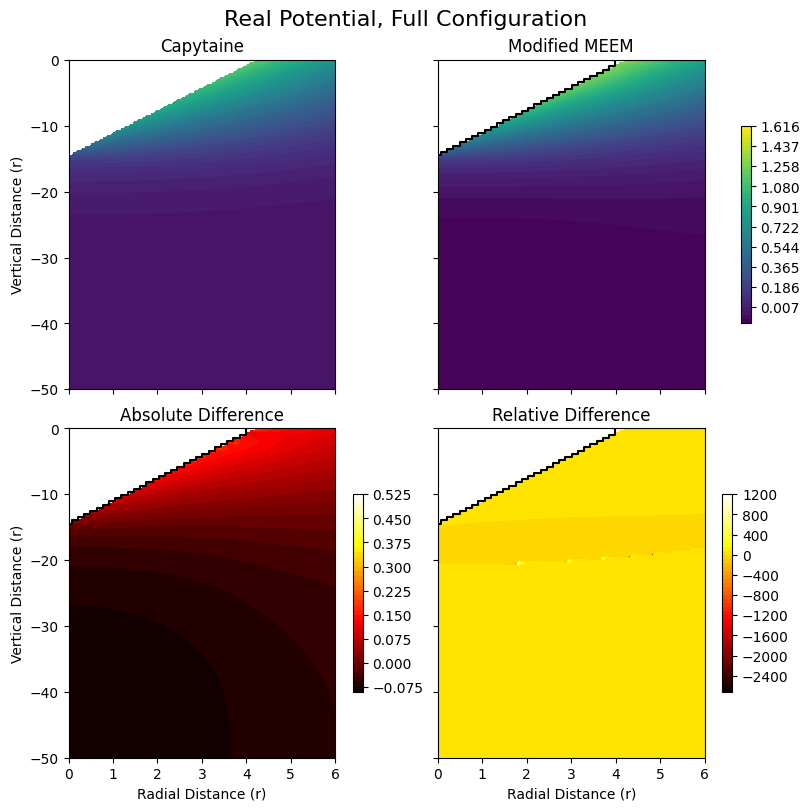

In [158]:
comparison(css, prob2, frame3, R3, Z3, cpt3_real_phi, mod23_real_phi, "Real Potential, Full Configuration")

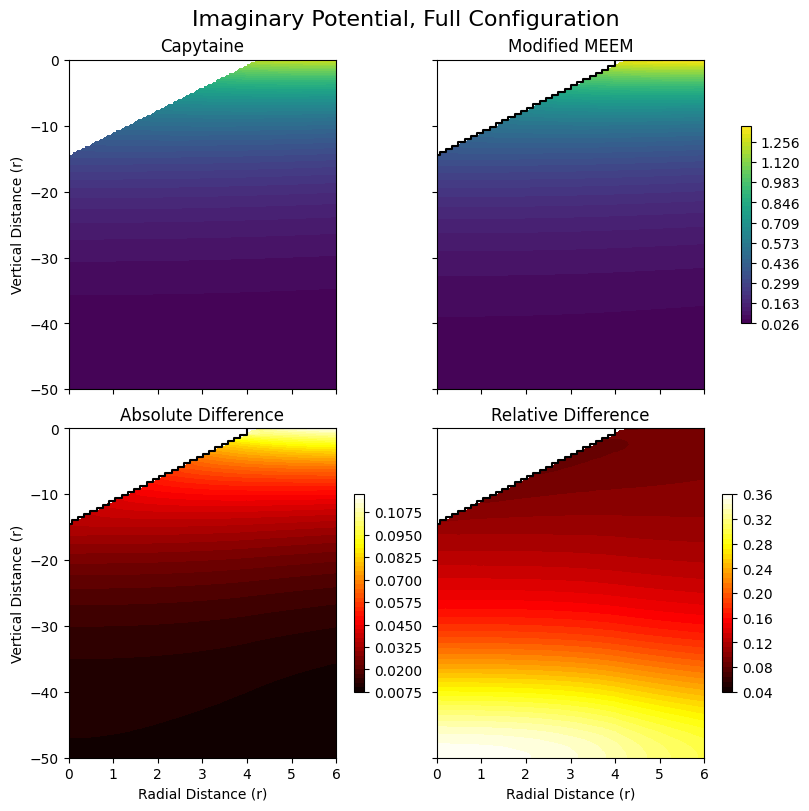

In [159]:
comparison(css, prob2, frame3, R3, Z3, cpt3_imag_phi, mod23_imag_phi, "Imaginary Potential, Full Configuration")

In [7]:
class ProblemWithRegion(Problem):
  def det_region(self, r):
      region = 0
      for i in range(self.boundary_count):
          if r <= self.a[i]:
              return region
          else: region += 1
      return region

def solve_regular_MEEM(h, a, d_in, d_out, heaving, m0, rho, subdivisions, version, NMK = NMK):
  d_prime, a_prime, heaving_prime, NMK_prime, slopes, d_in_prime, d_out_prime = slant_approx_vars(a, d_in, d_out, heaving, NMK, subdivisions, version)
  prob = ProblemWithRegion(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  return x, cs, prob

def potential_and_comparison(css, prob, cs, frame, plot_res_r, plot_res_z, cpt_real_phi, cpt_imag_phi):
   R, Z, meem_real_phi, meem_imag_phi = get_MEEM_potentials(prob, cs, frame, plot_res_r, plot_res_z)
   comparison(css, prob, frame, R, Z, cpt_real_phi, meem_real_phi, "Real Part of Potential")
   comparison(css, prob, frame, R, Z, cpt_imag_phi, meem_imag_phi, "Imaginary Part of Potential")

   

In [8]:
xr1, csr1, probr1 = solve_regular_MEEM(h, a, d_in, d_out, heaving, m0, rho, subdivisions, 1, NMK = NMK)
xr2, csr2, probr2 = solve_regular_MEEM(h, a, d_in, d_out, heaving, m0, rho, subdivisions, 2, NMK = NMK)

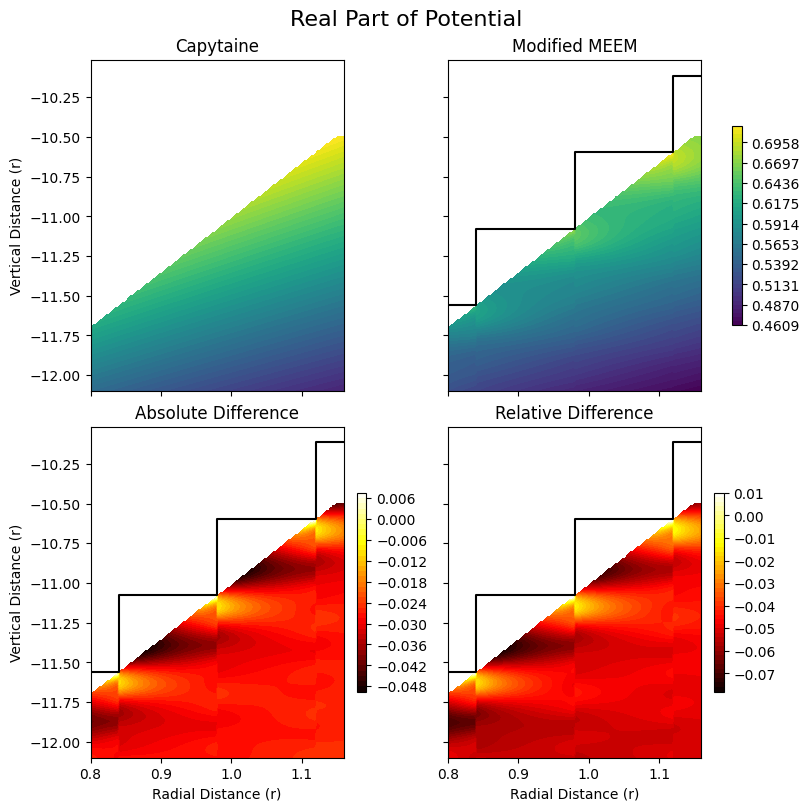

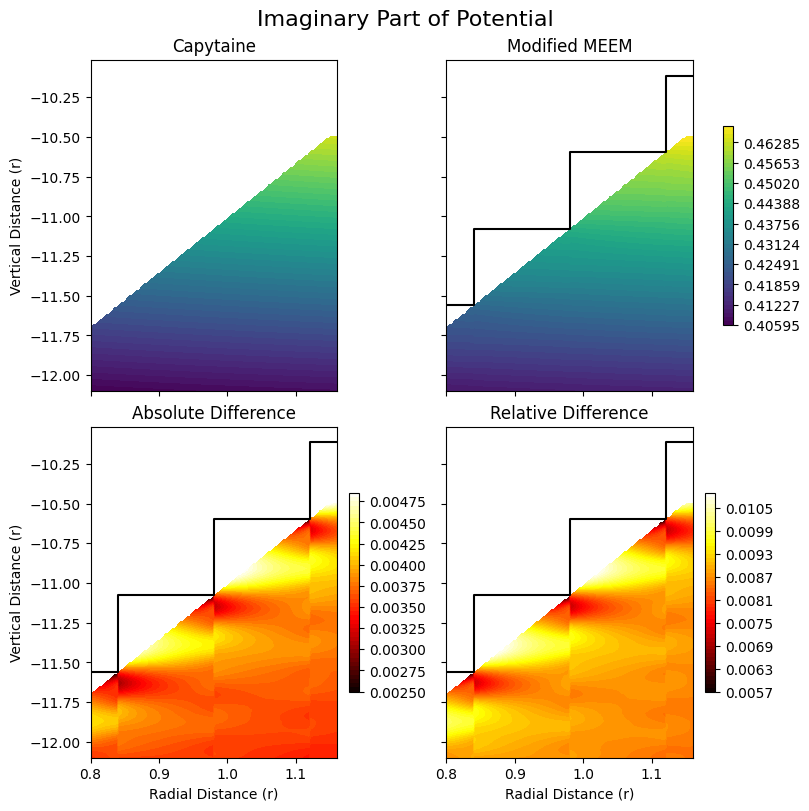

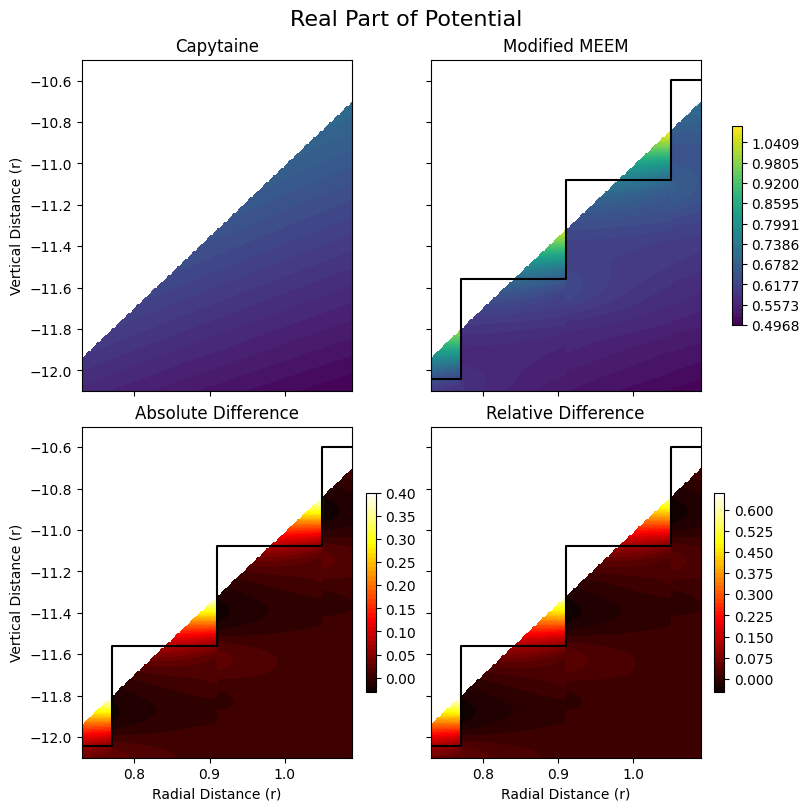

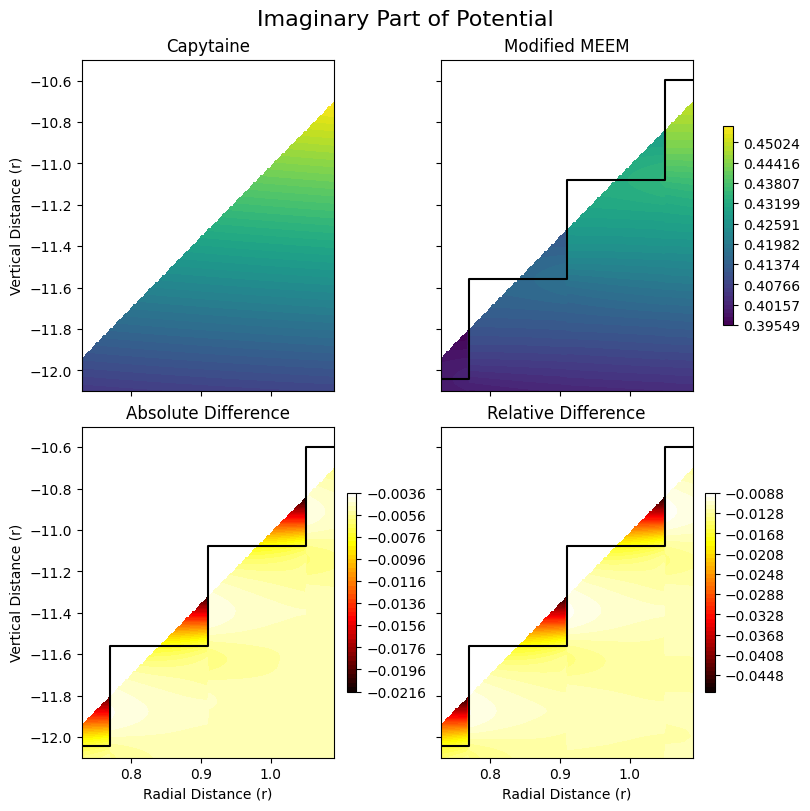

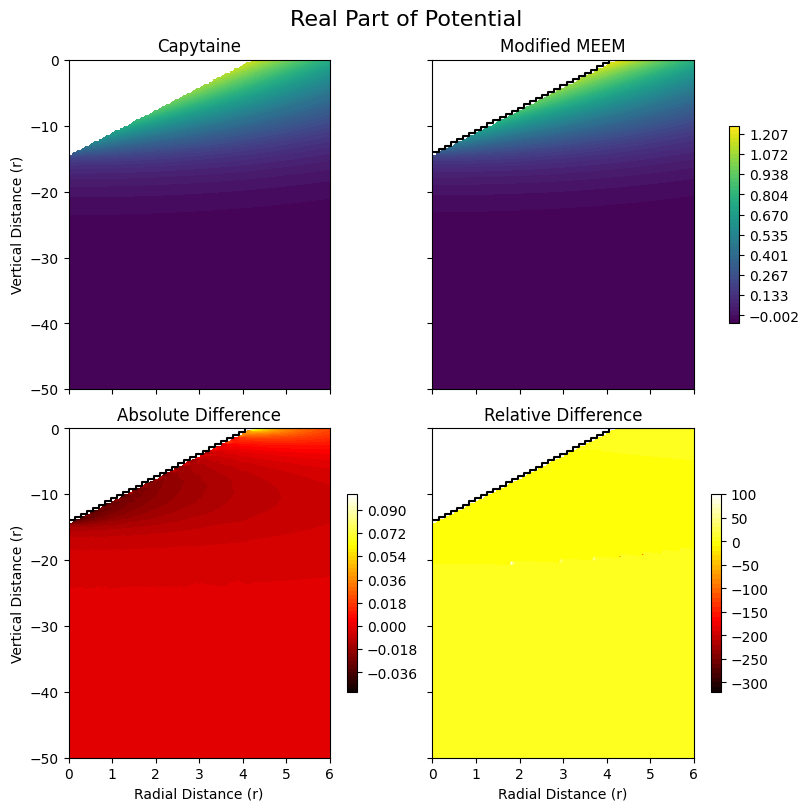

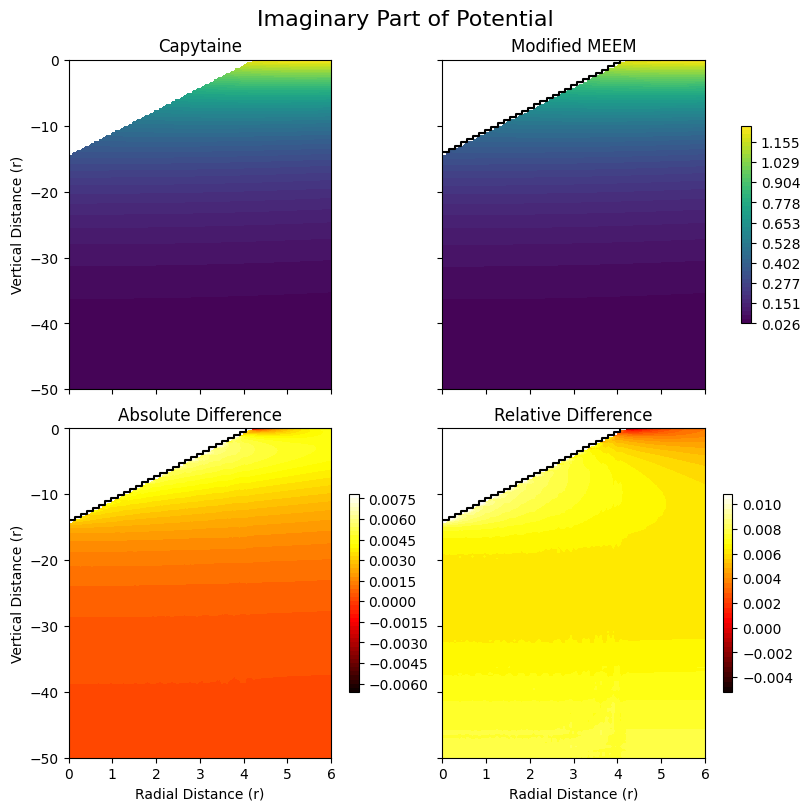

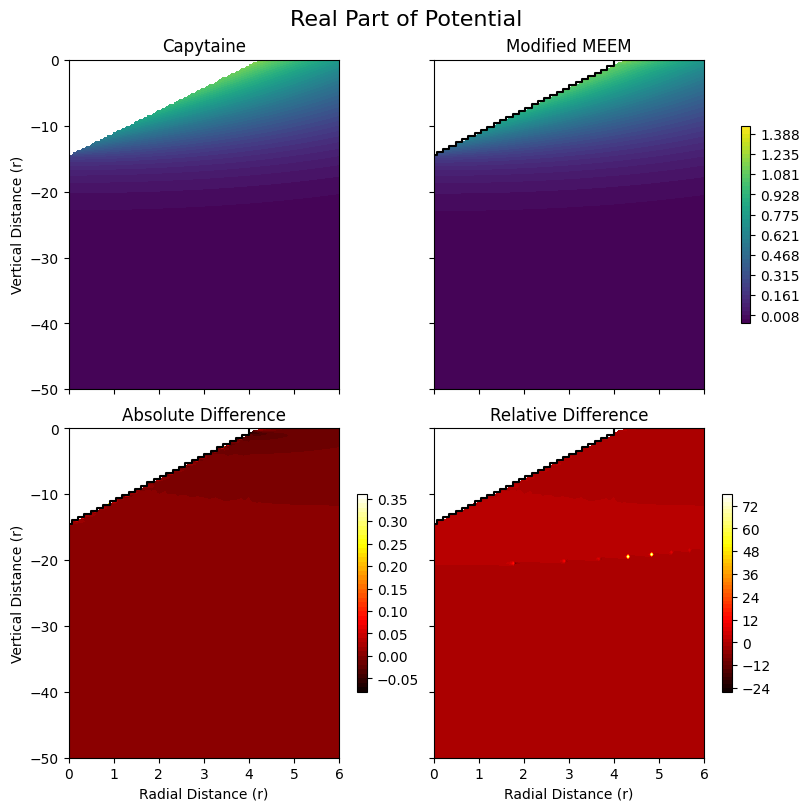

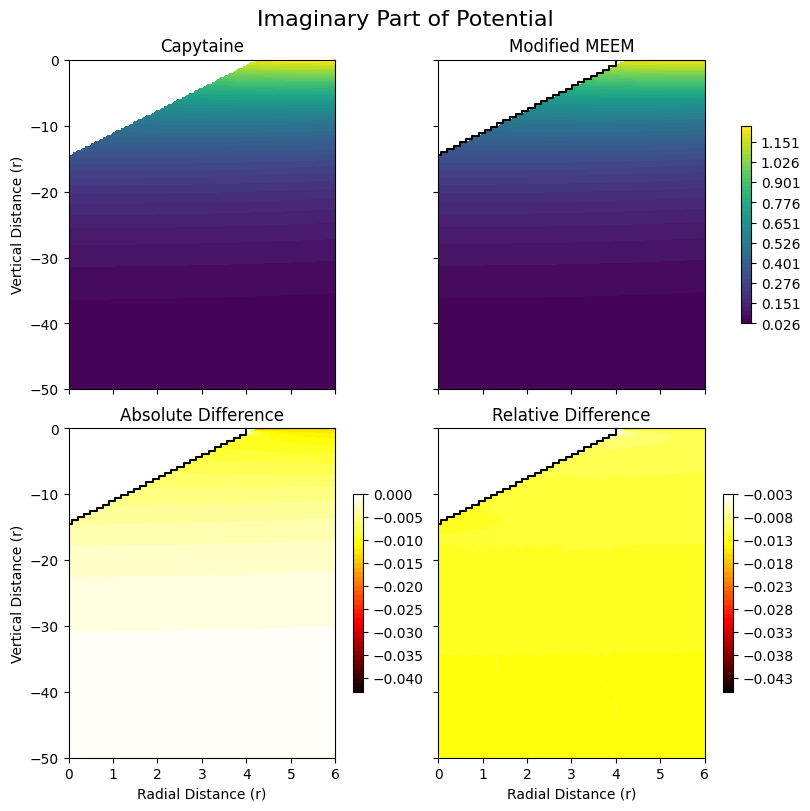

In [9]:
potential_and_comparison(css, probr1, csr1, frame1, plot_res_r, plot_res_z, cpt1_real_phi, cpt1_imag_phi)
potential_and_comparison(css, probr2, csr2, frame2, plot_res_r, plot_res_z, cpt2_real_phi, cpt2_imag_phi)
potential_and_comparison(css, probr1, csr1, frame3, plot_res_r, plot_res_z, cpt3_real_phi, cpt3_imag_phi)
potential_and_comparison(css, probr2, csr2, frame3, plot_res_r, plot_res_z, cpt3_real_phi, cpt3_imag_phi)